In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, Attention, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sweety18/cicids2017-full-dataset")

print("Path to dataset files:", path)

100%|██████████| 172M/172M [00:02<00:00, 78.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sweety18/cicids2017-full-dataset/versions/1


In [ ]:
file_path = "/root/.cache/kagglehub/datasets/sweety18/cicids2017-full-dataset/versions/1/combine.csv"
data = pd.read_csv(file_path)

<ipython-input-3-932e57b3affa>:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


In [ ]:
data.columns = data.columns.str.strip()


In [ ]:
columns_to_drop = ['Unnamed: 0', 'Flow ID', 'Source IP', 'Destination IP',
                   'Timestamp', 'Source Port', 'Destination Port', 'Protocol']
data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [ ]:
print(data['Label'].value_counts())


Label
BENIGN              1672837
DoS Hulk             231073
PortScan             158930
DDoS                 128027
DoS GoldenEye         10293
DoS slowloris          5796
DoS Slowhttptest       5499
Bot                    1966
Infiltration             36
Heartbleed               11
Name: count, dtype: int64


In [ ]:
data['Label'] = data['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)


In [ ]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinite values
data.fillna(data.median(), inplace=True)

In [ ]:
print("Dataset shape after preprocessing:", data.shape)
print(data.head())

Dataset shape after preprocessing: (2214469, 78)
   Flow Duration  Total Fwd Packets  Total Backward Packets  \
0            3.0                2.0                     0.0   
1          109.0                1.0                     1.0   
2           52.0                1.0                     1.0   
3           34.0                1.0                     1.0   
4            3.0                2.0                     0.0   

   Total Length of Fwd Packets  Total Length of Bwd Packets  \
0                         12.0                          0.0   
1                          6.0                          6.0   
2                          6.0                          6.0   
3                          6.0                          6.0   
4                         12.0                          0.0   

   Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
0                    6.0                    6.0                     6.0   
1                    6.0                   

In [ ]:
correlation_matrix = data.corr()
upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)
to_drop = [column for column in upper_triangle.columns if any(abs(upper_triangle[column]) > 0.9)]
data.drop(columns=to_drop, inplace=True)


In [ ]:
X = data.drop(columns=['Label'])
y = data['Label']

In [ ]:
print(data['Label'].value_counts())


Label
0    1672837
1     541632
Name: count, dtype: int64


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
X_benign = X_scaled[y == 0]
X_train, X_val = train_test_split(X_benign, test_size=0.25, random_state=42)
X_test = X_scaled[y == 1]  # All attack samples for testing

In [ ]:
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(30, activation='relu', kernel_regularizer=l2(0.001))(input_layer)
encoded = Dense(10, activation='relu', kernel_regularizer=l2(0.001))(encoded)
encoded = Dense(5, activation='relu', kernel_regularizer=l2(0.001))(encoded)
decoded = Dense(15, activation='relu', kernel_regularizer=l2(0.001))(encoded)
decoded = Dense(30, activation='relu', kernel_regularizer=l2(0.001))(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# Compile Autoencoder
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=1e-5), loss='mean_squared_error')

In [ ]:
history = autoencoder.fit(
    X_train, X_train,
    epochs=100,
    batch_size=1024,
    validation_data=(X_val, X_val),
    verbose=1
)


Epoch 1/100
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 1.2055 - val_loss: 1.1994
Epoch 2/100
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 1.1488 - val_loss: 1.1679
Epoch 3/100
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 1.1129 - val_loss: 1.1154
Epoch 4/100
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 1.0345 - val_loss: 1.0510
Epoch 5/100
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.9916 - val_loss: 0.9938
Epoch 6/100
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 1.0716 - val_loss: 0.9571
Epoch 7/100
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.9918 - val_loss: 0.9326
Epoch 8/100
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.8343 - val_loss: 0.9155
Epoch 9/100
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.8657 - val_loss: 0.9019
Epoch 10/100
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.8385 - val_loss: 0.8896
Epoch 11/100
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.8459 - val_loss: 0.8776
Epoch 12/100
1

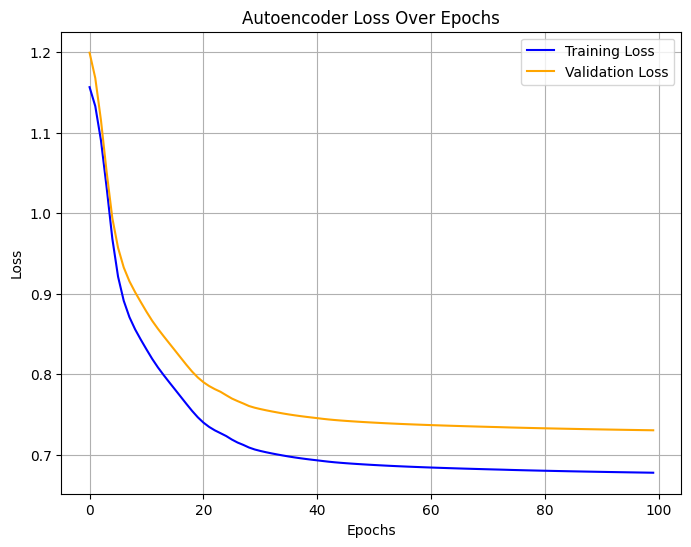

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Autoencoder Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Extract Encoder
encoder = Model(inputs=input_layer, outputs=encoded)

# Transform features using the encoder
X_encoded = encoder.predict(X_scaled)

69203/69203 ━━━━━━━━━━━━━━━━━━━━ 82s 1ms/step


In [ ]:
# Create sequences of data
time_steps = 10  # Define the number of time steps
X_sequential = []
for i in range(len(X_encoded) - time_steps):
    X_sequential.append(X_encoded[i:i + time_steps])
X_sequential = np.array(X_sequential)

In [ ]:
# Reshape the target labels to match the sequential data
y_sequential = y[time_steps:].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_sequential, y_sequential, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Dropout, Attention, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

input_dim = X_train.shape[2]
time_steps = X_train.shape[1]

input_layer = Input(shape=(time_steps, input_dim))
lstm = LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001))(input_layer)
dropout1 = Dropout(0.2)(lstm)
lstm2 = LSTM(32, return_sequences=True, kernel_regularizer=l2(0.001))(dropout1)
dropout2 = Dropout(0.2)(lstm2)

attention = Attention()([dropout2, dropout2])  # Self-attention mechanism
flattened = Flatten()(attention)
output = Dense(1, activation='sigmoid')(flattened)

# Compile LSTM model
lstm_model = Model(inputs=input_layer, outputs=output)
lstm_model.compile(optimizer=Adam(learning_rate=1e-6), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
lstm_history = lstm_model.fit(X_train, y_train,
                              epochs=10,
                              batch_size=256,
                              validation_data=(X_test, y_test))

Epoch 1/10
6921/6921 ━━━━━━━━━━━━━━━━━━━━ 347s 50ms/step - accuracy: 0.7912 - loss: 0.5197 - val_accuracy: 0.7937 - val_loss: 0.4920
Epoch 2/10
6921/6921 ━━━━━━━━━━━━━━━━━━━━ 342s 49ms/step - accuracy: 0.7956 - loss: 0.4877 - val_accuracy: 0.8045 - val_loss: 0.4597
Epoch 3/10
6921/6921 ━━━━━━━━━━━━━━━━━━━━ 341s 49ms/step - accuracy: 0.8082 - loss: 0.4567 - val_accuracy: 0.8207 - val_loss: 0.4210
Epoch 4/10
6921/6921 ━━━━━━━━━━━━━━━━━━━━ 384s 49ms/step - accuracy: 0.8269 - loss: 0.4219 - val_accuracy: 0.8709 - val_loss: 0.3858
Epoch 5/10
6921/6921 ━━━━━━━━━━━━━━━━━━━━ 381s 49ms/step - accuracy: 0.8470 - loss: 0.3944 - val_accuracy: 0.8846 - val_loss: 0.3624
Epoch 6/10
6921/6921 ━━━━━━━━━━━━━━━━━━━━ 371s 48ms/step - accuracy: 0.8622 - loss: 0.3743 - val_accuracy: 0.8920 - val_loss: 0.3471
Epoch 7/10
6921/6921 ━━━━━━━━━━━━━━━━━━━━ 396s 50ms/step - accuracy: 0.8708 - loss: 0.3618 - val_accuracy: 0.8954 - val_loss: 0.3362
Epoch 8/10
6921/6921 ━━━━━━━━━━━━━━━━━━━━ 347s 50ms/step - accuracy: 

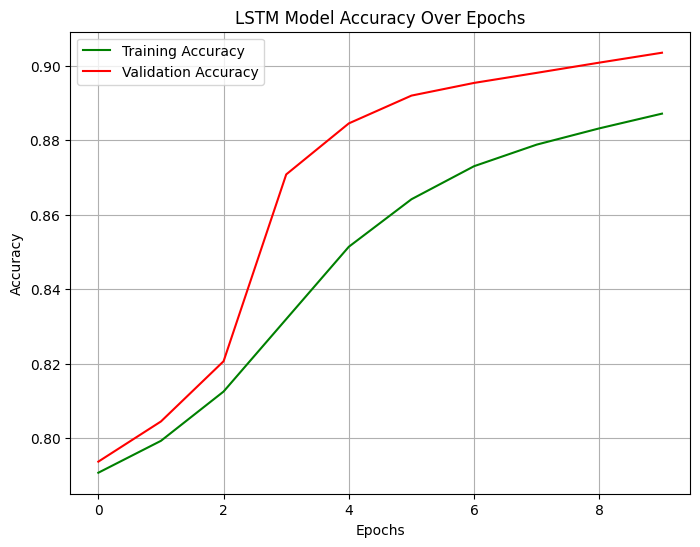

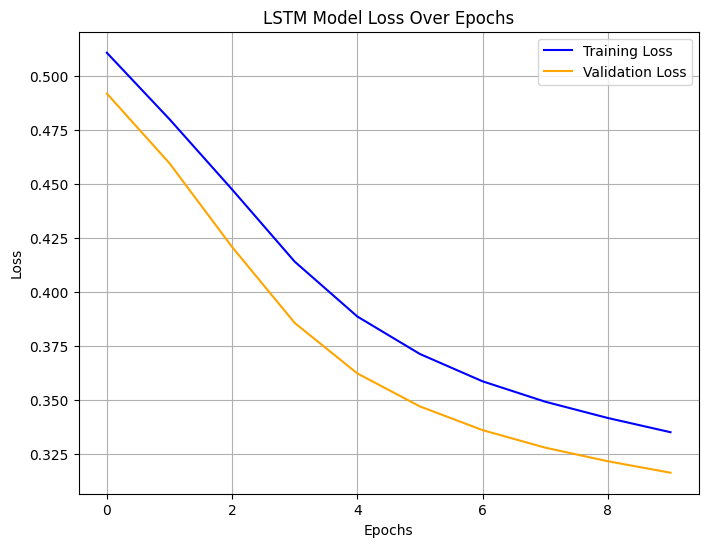

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(lstm_history.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(lstm_history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('LSTM Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot LSTM model loss
plt.figure(figsize=(8, 6))
plt.plot(lstm_history.history['loss'], label='Training Loss', color='blue')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('LSTM Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Make predictions
y_pred = lstm_model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

13841/13841 ━━━━━━━━━━━━━━━━━━━━ 59s 4ms/step



--- Classification Report ---
              precision    recall  f1-score   support

           0       0.94      0.93      0.94    334610
           1       0.79      0.83      0.81    108282

    accuracy                           0.90    442892
   macro avg       0.87      0.88      0.87    442892
weighted avg       0.91      0.90      0.90    442892



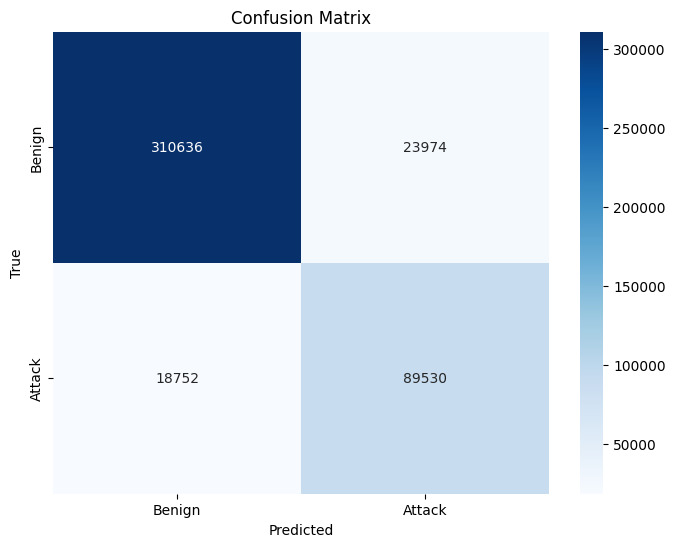

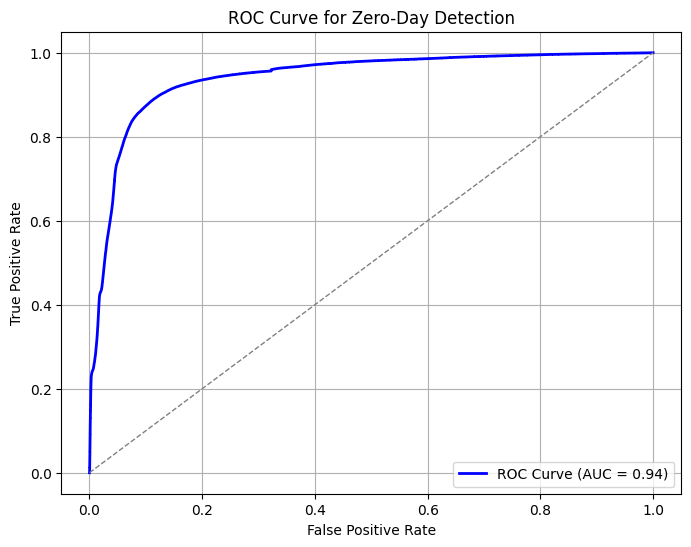

In [ ]:
# Classification Report
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred_binary))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Attack'], yticklabels=['Benign', 'Attack'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.title('ROC Curve for Zero-Day Detection')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


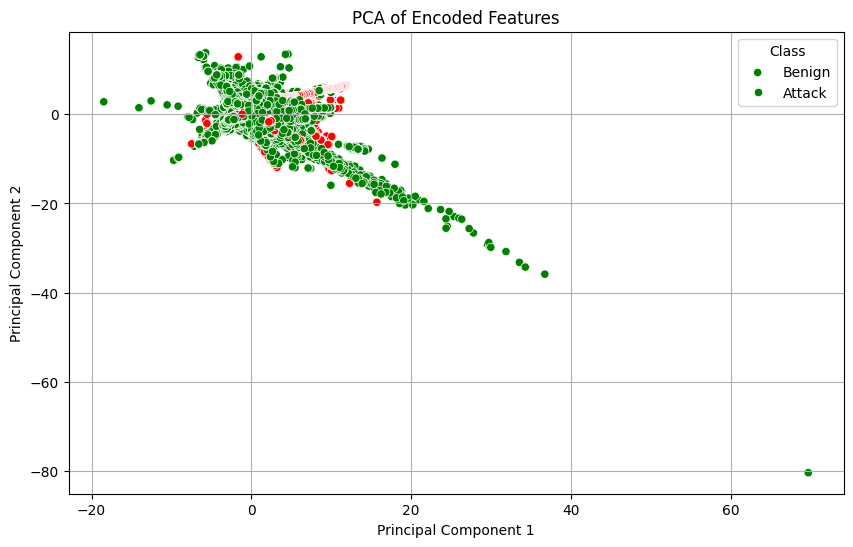

In [ ]:
from sklearn.decomposition import PCA
# PCA for Encoded Features

pca = PCA(n_components=2)
encoded_features_pca = pca.fit_transform(X_encoded)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=encoded_features_pca[:, 0], y=encoded_features_pca[:, 1], hue=y, palette={0: 'green', 1: 'red'}, legend='full')
plt.title('PCA of Encoded Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Class', labels=['Benign', 'Attack'])
plt.grid()
plt.show()